In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Preprocessing

## Price Data

In [ ]:
price_df = pd.read_csv('latest_data.csv')
price_df['Datetime'] = pd.to_datetime(price_df['Datetime'])
price_df['half hour'] = price_df['Datetime'].dt.strftime('%H:%M')

## SRLP Data

In [ ]:
# Load data

load_df = pd.read_csv('load_complete.csv')
load_df['Interval'] = pd.to_datetime(load_df['Interval'], format='%H:%M')
load_df['half hour'] = load_df['Interval'].dt.strftime('%H:%M')

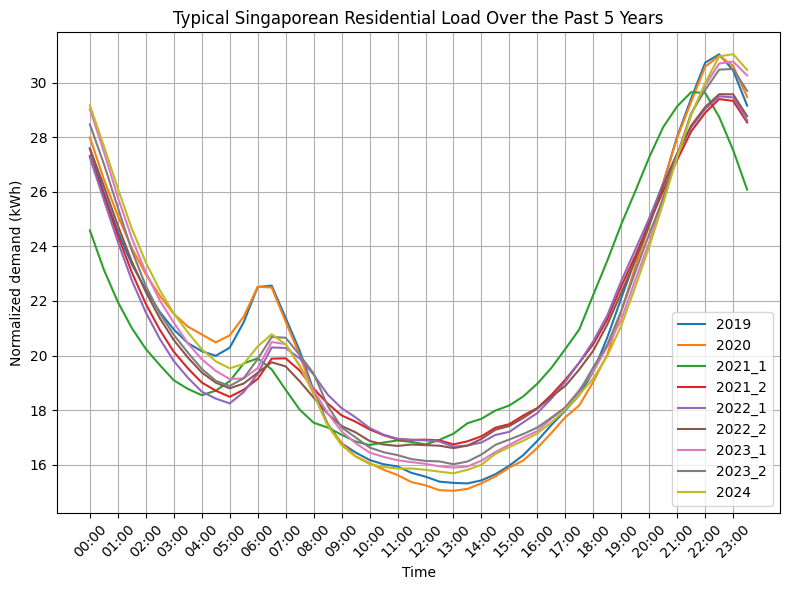

In [ ]:
# Plot comparison

x = np.arange(0, 48)
time_labels = [f"{int(i//2):02}:{int((i%2)*30):02}" for i in range(47+1)]


plt.figure(figsize=(8, 6))

for i in range(1, len(load_df.columns)-1):
    plt.plot(load_df.iloc[:, i], label=load_df.columns[i])

# Set custom ticks for the x-axis
plt.xticks(ticks=np.arange(0, 48, 2), labels=time_labels[::2], rotation=45)

plt.xlabel('Time')
plt.ylabel('Normalized demand (kWh)')
plt.title('Typical Singaporean Residential Load Over the Past 5 Years')
plt.legend(loc='lower right')

plt.grid(True)

plt.tight_layout()
plt.show()

Over the past 5 years, the profile remains relatively the same

To calculate the typical monthly bill, we select the 2024 trend as it is more relevant to the current date


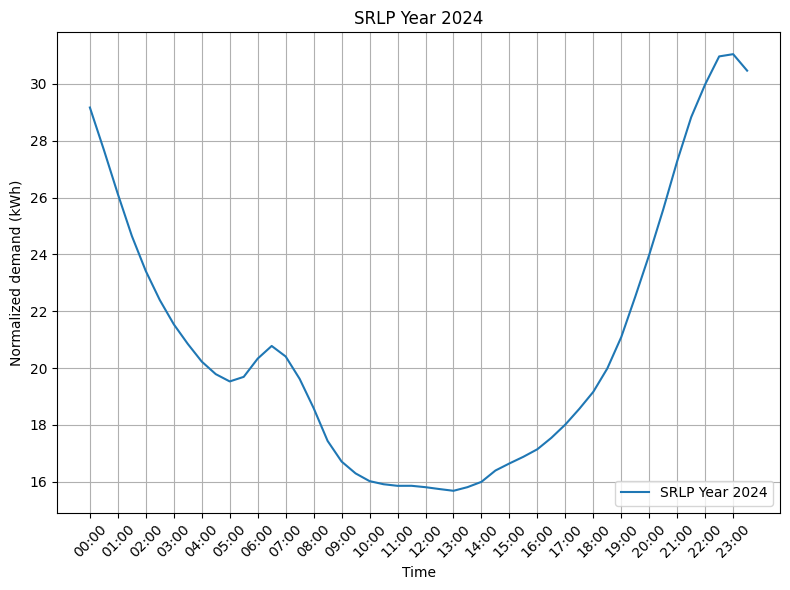

In [ ]:
# Plot comparison

x = np.arange(0, 48)
time_labels = [f"{int(i//2):02}:{int((i%2)*30):02}" for i in range(47+1)]


plt.figure(figsize=(8, 6))

plt.plot(load_df['2024'], label='SRLP Year 2024')

# Set custom ticks for the x-axis
plt.xticks(ticks=np.arange(0, 48, 2), labels=time_labels[::2], rotation=45)

plt.xlabel('Time')
plt.ylabel('Normalized demand (kWh)')
plt.title('SRLP Year 2024')
plt.legend(loc='lower right')

plt.grid(True)

plt.tight_layout()
plt.show()

## Combined price and SRLP

In [ ]:
price_df['half hour'] = price_df['half hour'].str.strip()
load_df['half hour'] = load_df['half hour'].str.strip()

In [ ]:
df = price_df.merge(load_df[['half hour', '2024']], on='half hour', how='left')
df.rename(columns={'2024':'SRLP'}, inplace=True)

For calculating the bill, I scaled down the SRLP to be normalized to 12 kWh/day. This will give a more reasonable monthly household electricity consumption, i.e., around 364 kWh/month

In [ ]:
multiplier = 12
df['SRLP_normalized'] = df['SRLP']*multiplier/1000
df['dynamic bill (cents)'] = df['SRLP_normalized']*df['USEP (c/kWh)']

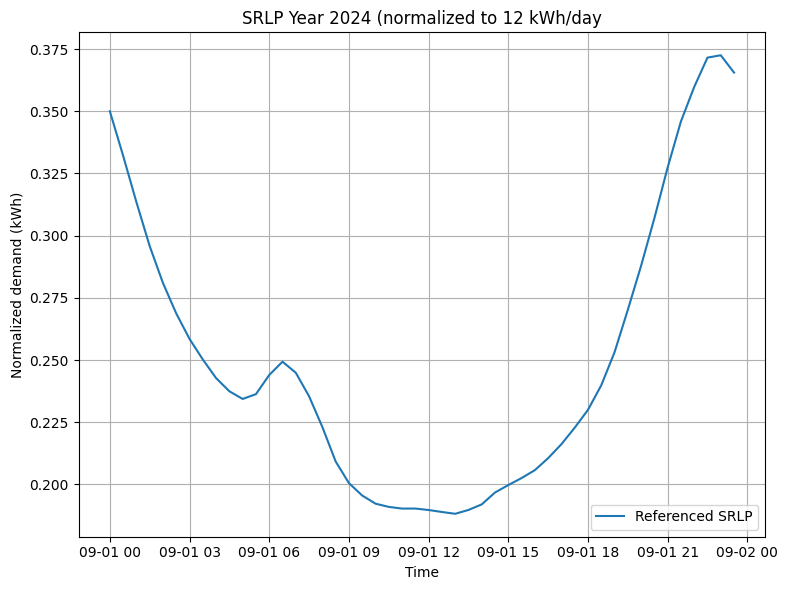

In [ ]:
# REFERENCED SRLP

start = pd.to_datetime('2023-09-01 00:00')
end = pd.to_datetime('2023-09-01 23:30')
referenced_df = df[df['Datetime'].between(start, end)]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(referenced_df['Datetime'], referenced_df['SRLP_normalized'], label='Referenced SRLP')

plt.xlabel('Time')
plt.ylabel('Normalized demand (kWh)')
plt.title('SRLP Year 2024 (normalized to 12 kWh/day')
plt.legend(loc='lower right')

plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
referenced_df.to_csv('data/referenced_df.csv', index=False)

OSError: Cannot save file into a non-existent directory: 'data'

In [ ]:
df['month'] = df['Datetime'].dt.to_period('M')

# Cost Saving Simulation

## Regulated Tariff

Using the normalized SRLP to 10 kWh/day, and regulated tariff as follows:

Sep 2023: 29.96 c/kWh

Oct - Dec 2023: 31 c/kWh

Jan - Mar 2024: 32.58 c/kWh

Apr - Jun 2024: 32.47 c/kWh

Jul - Sep 2024: 32.57 c/kWh


In [ ]:
tariff_intervals = {
    ('2023-08', '2023-09'): 29.96,
    ('2023-10', '2023-12'): 31.00,
    ('2024-01', '2024-03'): 32.58,
    ('2024-04', '2024-06'): 32.47,
    ('2024-07', '2024-09'): 32.57
}

In [ ]:
def assign_tariff(date):
    for (start, end), tariff in tariff_intervals.items():
        if pd.Period(start) <= pd.Period(date, freq='M') <= pd.Period(end):
            return tariff
    return None  # For dates outside the defined intervals

# Add the new column 'regulated tariff (c/kWh)' based on the Datetime column
df['regulated tariff (c/kWh)'] = df['Datetime'].dt.to_period('M').apply(assign_tariff)

In [ ]:
df['regulated bill (cents)'] = df['SRLP_normalized']*df['regulated tariff (c/kWh)']

In [ ]:
regulated_monthly_bill = df.groupby('month')['regulated bill (cents)'].sum()/100

<ipython-input-34-8eada35aed8e>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([pd.Period(m).strftime('%b %Y') for m in regulated_monthly_bill.index], rotation=45)


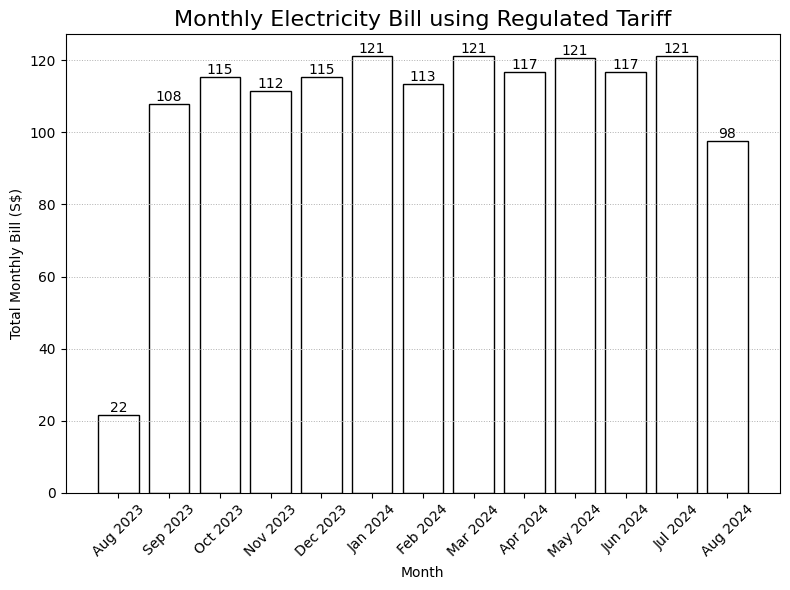

In [ ]:
# PLOTTING

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(regulated_monthly_bill.index.astype(str), regulated_monthly_bill.values, color='white', edgecolor='black')

# Format x-axis labels to display in "MMM YYYY" format
ax.set_xticklabels([pd.Period(m).strftime('%b %Y') for m in regulated_monthly_bill.index], rotation=45)

# Set labels and title
ax.set_title('Monthly Electricity Bill using Regulated Tariff', fontsize=16)
ax.set_ylabel('Total Monthly Bill (S$)')
ax.set_xlabel('Month')

# Show grid for better readability
ax.grid(True, axis='y', linestyle=':', linewidth=0.7)

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

## Dynamic Pricing

In [ ]:
dynamic_monthly_bill = df.groupby('month')['dynamic bill (cents)'].sum()/100

<ipython-input-36-65e121696a63>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([pd.Period(m).strftime('%b %Y') for m in dynamic_monthly_bill.index], rotation=45)


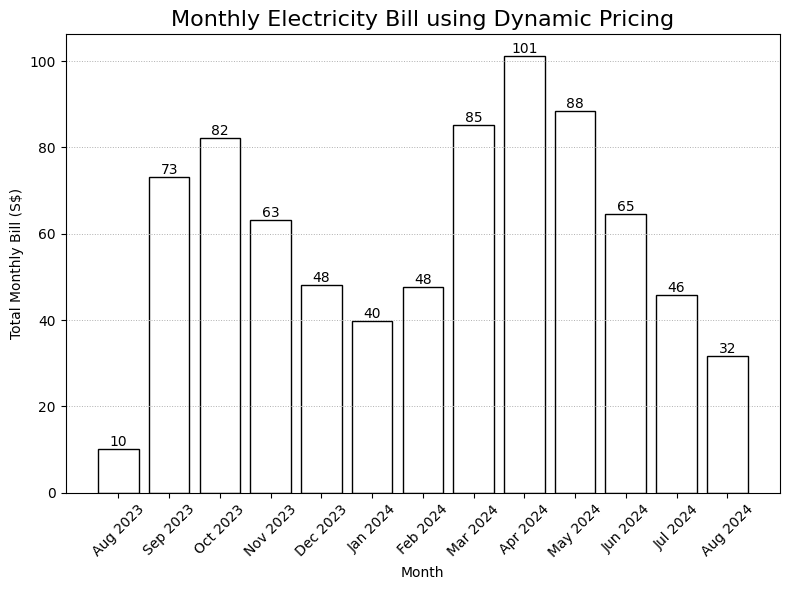

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(dynamic_monthly_bill.index.astype(str), dynamic_monthly_bill.values, color='white', edgecolor='black')

# Format x-axis labels to display in "MMM YYYY" format
ax.set_xticklabels([pd.Period(m).strftime('%b %Y') for m in dynamic_monthly_bill.index], rotation=45)

# Set labels and title
ax.set_title('Monthly Electricity Bill using Dynamic Pricing', fontsize=16)
ax.set_ylabel('Total Monthly Bill (S$)')
ax.set_xlabel('Month')

# Show grid for better readability
ax.grid(True, axis='y', linestyle=':', linewidth=0.7)

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

# Redefining Price Surge

## Method 1: Based on percentage increase

Surge is categorized into 3 types to cater to different types of consumers
1. Type I: Increase of more than 100% and the price is above 30 c/kWh (Less sensitive consumers)
2. Type II: Increase of more than 75% and the price is above Q3 (Moderately sensitive consumers)
3. Type III: Increase of more than 50% and the price is above median (Highly sensitive consumers)

Median: 13.38 c/kWh \
Q3: 17.73 c/kWh

In [ ]:
redefine_df1 = df.copy()
redefine_df1['Percentage Change'] = redefine_df1['USEP (c/kWh)'].diff() / redefine_df1['USEP (c/kWh)'].shift(1) * 100

In [ ]:
redefine_df1['Type I'] = (redefine_df1['USEP (c/kWh)'] > 30) & (redefine_df1['Percentage Change'] > 100)
redefine_df1['Type II'] = (redefine_df1['USEP (c/kWh)'] > 17.75) & (redefine_df1['Percentage Change'] > 75)
redefine_df1['Type III'] = (redefine_df1['USEP (c/kWh)'] > 13.38) & (redefine_df1['Percentage Change'] > 50)